# Import Libraries

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda ,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19

%matplotlib inline
import os
import cv2
from tensorflow import keras
from keras.models import Sequential



## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving archive (2).zip to archive (2).zip


In [ ]:
import zipfile

zip_file_name = 'archive (2).zip'  # Replace with the name of your uploaded zip file

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
#define the path to image folder in Google Drive
folder_path = "/content/asl_dataset"

#load data
data = tf.keras.preprocessing.image_dataset_from_directory(folder_path)

Found 5030 files belonging to 37 classes.


## Sample Images

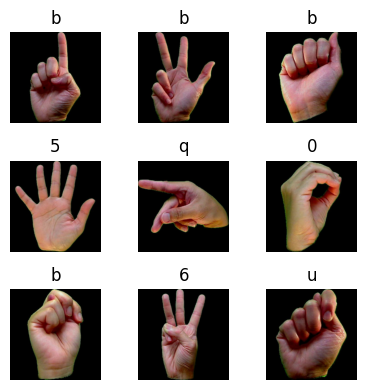

In [ ]:
#visualize images
import matplotlib.pyplot as plt

#dictionary between label and sign
categories = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",
              'a':"a",'b':"b",'c':"c",'d':"d",'e':"e",'f':"f",'g':"g",'h':"h",
              'i':"i",'j':"j",'k':"k",'l':"l",'m':"m",'n':"n",'o':"o",'p':"p",
              'q':"q",'r':"r",'s':"s",'t':"t",'u':"u",'v':"v",'w':"w",'x':"x",
              'y':"y",'z':"z"}

#take the first 9 images from the dataset
images, labels = next(iter(data.take(9)))

#display the images
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #get the category name from the dictionary
    category_name = list(categories.keys())[labels[i].numpy()]
    plt.title(category_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#create dataframe
import os
from matplotlib.image import imread
import numpy as np
import pandas as pd

root_dir = os.listdir(folder_path)
file_list = []
image_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{folder_path}/{directory}"
    if not os.path.isdir(directory_path) or directory=='asl_dataset':
        continue
    for files in os.listdir(f"{folder_path}/{directory}"):
        file_path = f"{folder_path}/{directory}/{files}"
        file_list.append(file_path)
        label_list.append(directory)
        img = imread(file_path)
        image_list.append(np.array(img))
df = pd.DataFrame({'file':file_list,'image':image_list,'label':label_list})

print(df.head())

                                                file  \
0  /content/asl_dataset/o/hand5_o_dif_seg_1_cropp...   
1  /content/asl_dataset/o/hand2_o_left_seg_4_crop...   
2  /content/asl_dataset/o/hand1_o_right_seg_5_cro...   
3  /content/asl_dataset/o/hand4_o_bot_seg_3_cropp...   
4  /content/asl_dataset/o/hand1_o_left_seg_4_crop...   

                                               image label  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     o  
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     o  
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     o  
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     o  
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...     o  


### Number of entries in each class

<ipython-input-71-b1a20c7711f3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label, palette='Set1')


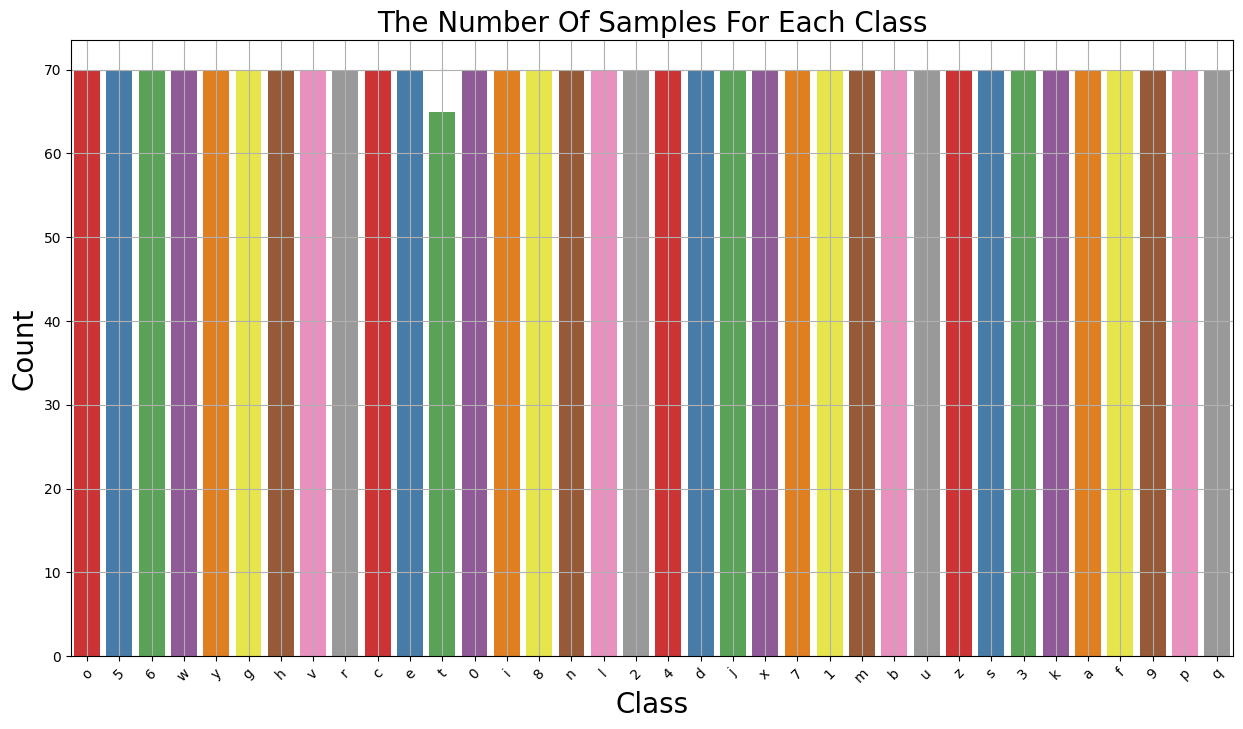

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df.label, palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Train, Validation, Test Split

In [ ]:
#split dataframe into train, test, and validation
#split train test first
from sklearn.model_selection import train_test_split

x_train, x_test0, y_train, y_test0 = train_test_split(
    df['file'], df['label'], test_size = 0.30, stratify = df['label'], random_state = 42)

In [ ]:
#split the test0 set in half again to test and validation

x_test, x_val, y_test, y_val = train_test_split(
    x_test0, y_test0, test_size = 0.5, stratify = y_test0, random_state = 42)

#concatenate the train and test dataframes

train = pd.concat([x_train,y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test,y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)

#check the shape of each dataframe

print(np.shape(train))
print(np.shape(test))
print(np.shape(val))

(1760, 2)
(377, 2)
(378, 2)


## Transform Images

In [ ]:
#preprocess data parameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

#defining height, width, channels, batch size, and image size and shape

height = 228
width = 228
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

#train, test, val split

train_data = datagen.flow_from_dataframe(
    dataframe = train,
    x_col = 'file',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'file',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = False)

val_data = datagen.flow_from_dataframe(
    dataframe = val,
    x_col = 'file',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = False)

Found 1760 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.


## **Model Training: VGG16, Resnet, InceptionV3**

## Use pretrained model layers

In [ ]:
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50

def load_pretrained_model(model_name, img_shape, trainable=False):
    if model_name == 'InceptionV3':
        pretrain = InceptionV3(weights='imagenet', include_top=False,
                               input_shape=img_shape, pooling='avg')
    elif model_name == 'VGG16':
        pretrain = VGG16(weights='imagenet', include_top=False,
                         input_shape=img_shape, pooling='avg')
    elif model_name == 'ResNet50':
        pretrain = ResNet50(weights='imagenet', include_top=False,
                            input_shape=img_shape, pooling='avg')
    else:
        raise ValueError("Unsupported model: {}".format(model_name))

    # Freeze the layers
    for layer in pretrain.layers:
        layer.trainable = trainable

    return pretrain



## Add Custom Layer



In [ ]:
def build_model(pretrained_model, learning_rate=0.005):
    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(36, activation='softmax')
    ])

    opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Train and Evaluate with Call back

* **Activation L1** = Relu
* **Activation L2** = Softmax
* **Loss** = Categorical Cross Entropy
* **Metric** = Accuracy
* **Drop out** = 0.2
* **Learning Rate** = 0.01
* **Batch Size** = 16
* **Epoch** = 50
* **Patience** = 10

In [ ]:
from tensorflow.keras import callbacks

def train_and_evaluate(model_name, img_shape, train_data, test_data, val_data):
    best_accuracy = 0
    best_params = None
    best_model = None

    print(f"Training model: {model_name}")

    pretrain = load_pretrained_model(model_name, img_shape)

    model = build_model(pretrain, learning_rate=0.01)
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=10,
        ),
        callbacks.ModelCheckpoint(
            filepath="checkpoint_path.keras",
            monitor="val_loss",
            save_best_only=True,
        )
    ]

    history = model.fit(train_data, validation_data=val_data,
                        epochs=50, batch_size=16, callbacks=callbacks_list, verbose=1)

    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model

    return best_model, best_accuracy


## **VGG16 + Custom**

In [ ]:
best_model_VGG16, best_accuracy_VGG16 = train_and_evaluate('VGG16', img_shape, train_data, test_data, val_data)

print(f"Best Validation Accuracy for VGG16: {best_accuracy_VGG16}")

# Save the best model with a filename that includes the model name
model_save_path = f'VGG16_best_model.h5'
best_model_VGG16.save(model_save_path)
print(f"Model saved as {model_save_path}")

Training model: VGG16
Epoch 1/50
14/14 [==============================] - 38s 2s/step - loss: 2.4956 - accuracy: 0.4563 - val_loss: 3.7758 - val_accuracy: 0.0820
Epoch 2/50
14/14 [==============================] - 37s 3s/step - loss: 1.2730 - accuracy: 0.7068 - val_loss: 3.6277 - val_accuracy: 0.1164
Epoch 3/50
14/14 [==============================] - 32s 2s/step - loss: 0.8221 - accuracy: 0.7716 - val_loss: 3.3301 - val_accuracy: 0.1085
Epoch 4/50
14/14 [==============================] - 33s 2s/step - loss: 0.6507 - accuracy: 0.8119 - val_loss: 3.3252 - val_accuracy: 0.0952
Epoch 5/50
14/14 [==============================] - 32s 2s/step - loss: 0.5355 - accuracy: 0.8188 - val_loss: 3.2825 - val_accuracy: 0.0423
Epoch 6/50
14/14 [==============================] - 32s 2s/step - loss: 0.5193 - accuracy: 0.8455 - val_loss: 3.2340 - val_accuracy: 0.1984
Epoch 7/50
14/14 [==============================] - 33s 2s/step - loss: 0.5404 - accuracy: 0.8335 - val_loss: 3.3365 - val_accuracy: 0.190

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


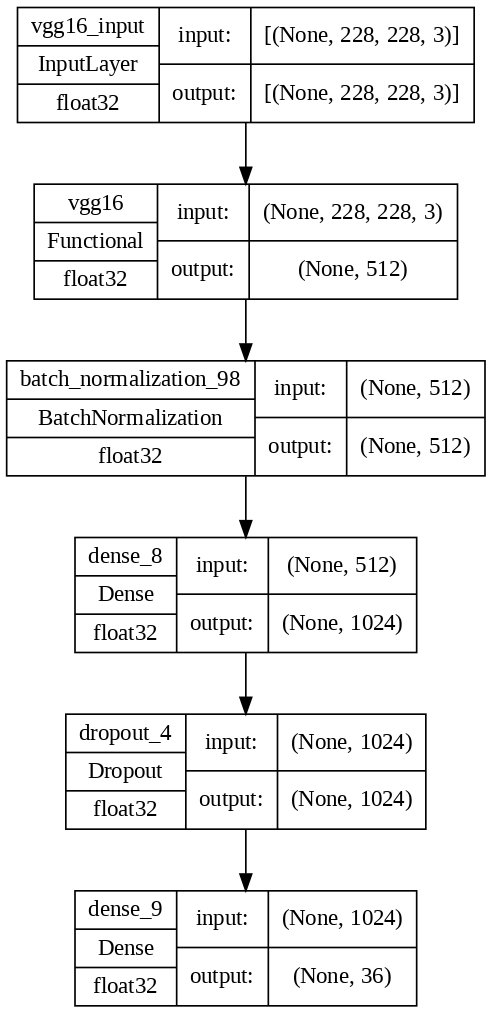

In [ ]:
tf.keras.utils.plot_model(best_model_VGG16, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

## **InceptionV3 + Custom**

In [ ]:
best_model_InceptionV3, best_accuracy_InceptionV3 = train_and_evaluate('InceptionV3', img_shape, train_data, test_data, val_data)

print(f"Best Validation Accuracy for InceptionV3: {best_accuracy_InceptionV3}")

# Save the best model with a filename that includes the model name
model_save_path = f'InceptionV3_best_model.h5'
best_model_InceptionV3.save(model_save_path)
print(f"Model saved as {model_save_path}")

Training model: InceptionV3
Epoch 1/50
14/14 [==============================] - 39s 2s/step - loss: 15.9656 - accuracy: 0.2642 - val_loss: 17.4946 - val_accuracy: 0.1243
Epoch 2/50
14/14 [==============================] - 31s 2s/step - loss: 9.7859 - accuracy: 0.4744 - val_loss: 8.5579 - val_accuracy: 0.2513
Epoch 3/50
14/14 [==============================] - 31s 2s/step - loss: 6.4990 - accuracy: 0.5415 - val_loss: 5.4740 - val_accuracy: 0.3545
Epoch 4/50
14/14 [==============================] - 33s 2s/step - loss: 4.9604 - accuracy: 0.5693 - val_loss: 2.3235 - val_accuracy: 0.4101
Epoch 5/50
14/14 [==============================] - 31s 2s/step - loss: 2.6555 - accuracy: 0.6330 - val_loss: 2.1944 - val_accuracy: 0.3651
Epoch 6/50
14/14 [==============================] - 29s 2s/step - loss: 1.5039 - accuracy: 0.6591 - val_loss: 2.3288 - val_accuracy: 0.3439
Epoch 7/50
14/14 [==============================] - 32s 2s/step - loss: 1.1139 - accuracy: 0.6898 - val_loss: 2.0458 - val_accurac

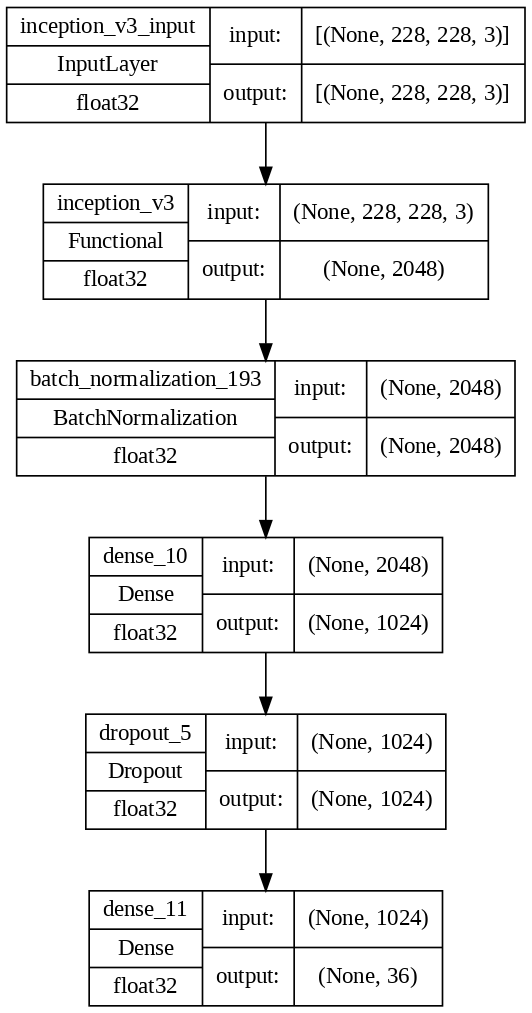

In [ ]:
tf.keras.utils.plot_model(best_model_InceptionV3, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

## **Resnet50 + Custom**

In [ ]:
best_model_ResNet50, best_accuracy_ResNet50 = train_and_evaluate('ResNet50', img_shape, train_data, test_data, val_data)

print(f"Best Validation Accuracy for ResNet50: {best_accuracy_ResNet50}")

# Save the best model with a filename that includes the model name
model_save_path = f'ResNet50_best_model.h5'
best_model_ResNet50.save(model_save_path)
print(f"Model saved as {model_save_path}")

Training model: ResNet50
Epoch 1/50
14/14 [==============================] - 44s 3s/step - loss: 7.9779 - accuracy: 0.0739 - val_loss: 3.9419 - val_accuracy: 0.0265
Epoch 2/50
14/14 [==============================] - 32s 2s/step - loss: 3.6521 - accuracy: 0.0943 - val_loss: 3.6604 - val_accuracy: 0.0317
Epoch 3/50
14/14 [==============================] - 33s 2s/step - loss: 3.0667 - accuracy: 0.1250 - val_loss: 3.9939 - val_accuracy: 0.0265
Epoch 4/50
14/14 [==============================] - 31s 2s/step - loss: 2.9062 - accuracy: 0.1437 - val_loss: 3.9517 - val_accuracy: 0.0265
Epoch 5/50
14/14 [==============================] - 32s 2s/step - loss: 2.8082 - accuracy: 0.1636 - val_loss: 4.0162 - val_accuracy: 0.0265
Epoch 6/50
14/14 [==============================] - 31s 2s/step - loss: 2.7734 - accuracy: 0.1648 - val_loss: 4.0060 - val_accuracy: 0.0503
Epoch 7/50
14/14 [==============================] - 31s 2s/step - loss: 2.6945 - accuracy: 0.1773 - val_loss: 3.9958 - val_accuracy: 0.

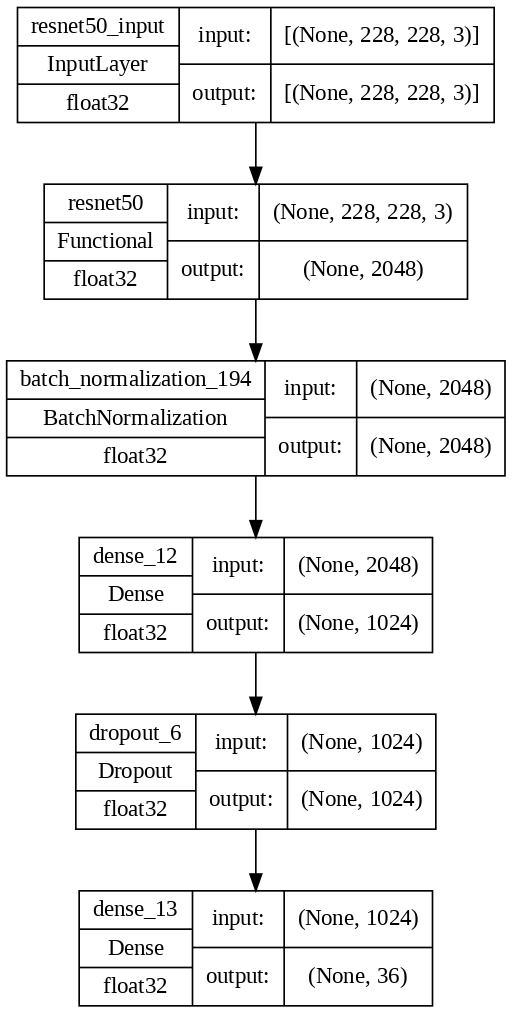

In [ ]:
tf.keras.utils.plot_model(best_model_ResNet50, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# **Results**

## Train and Validation Results

### VGG16, InceptionV3, Resnet50 Loss and Accuracy comparison

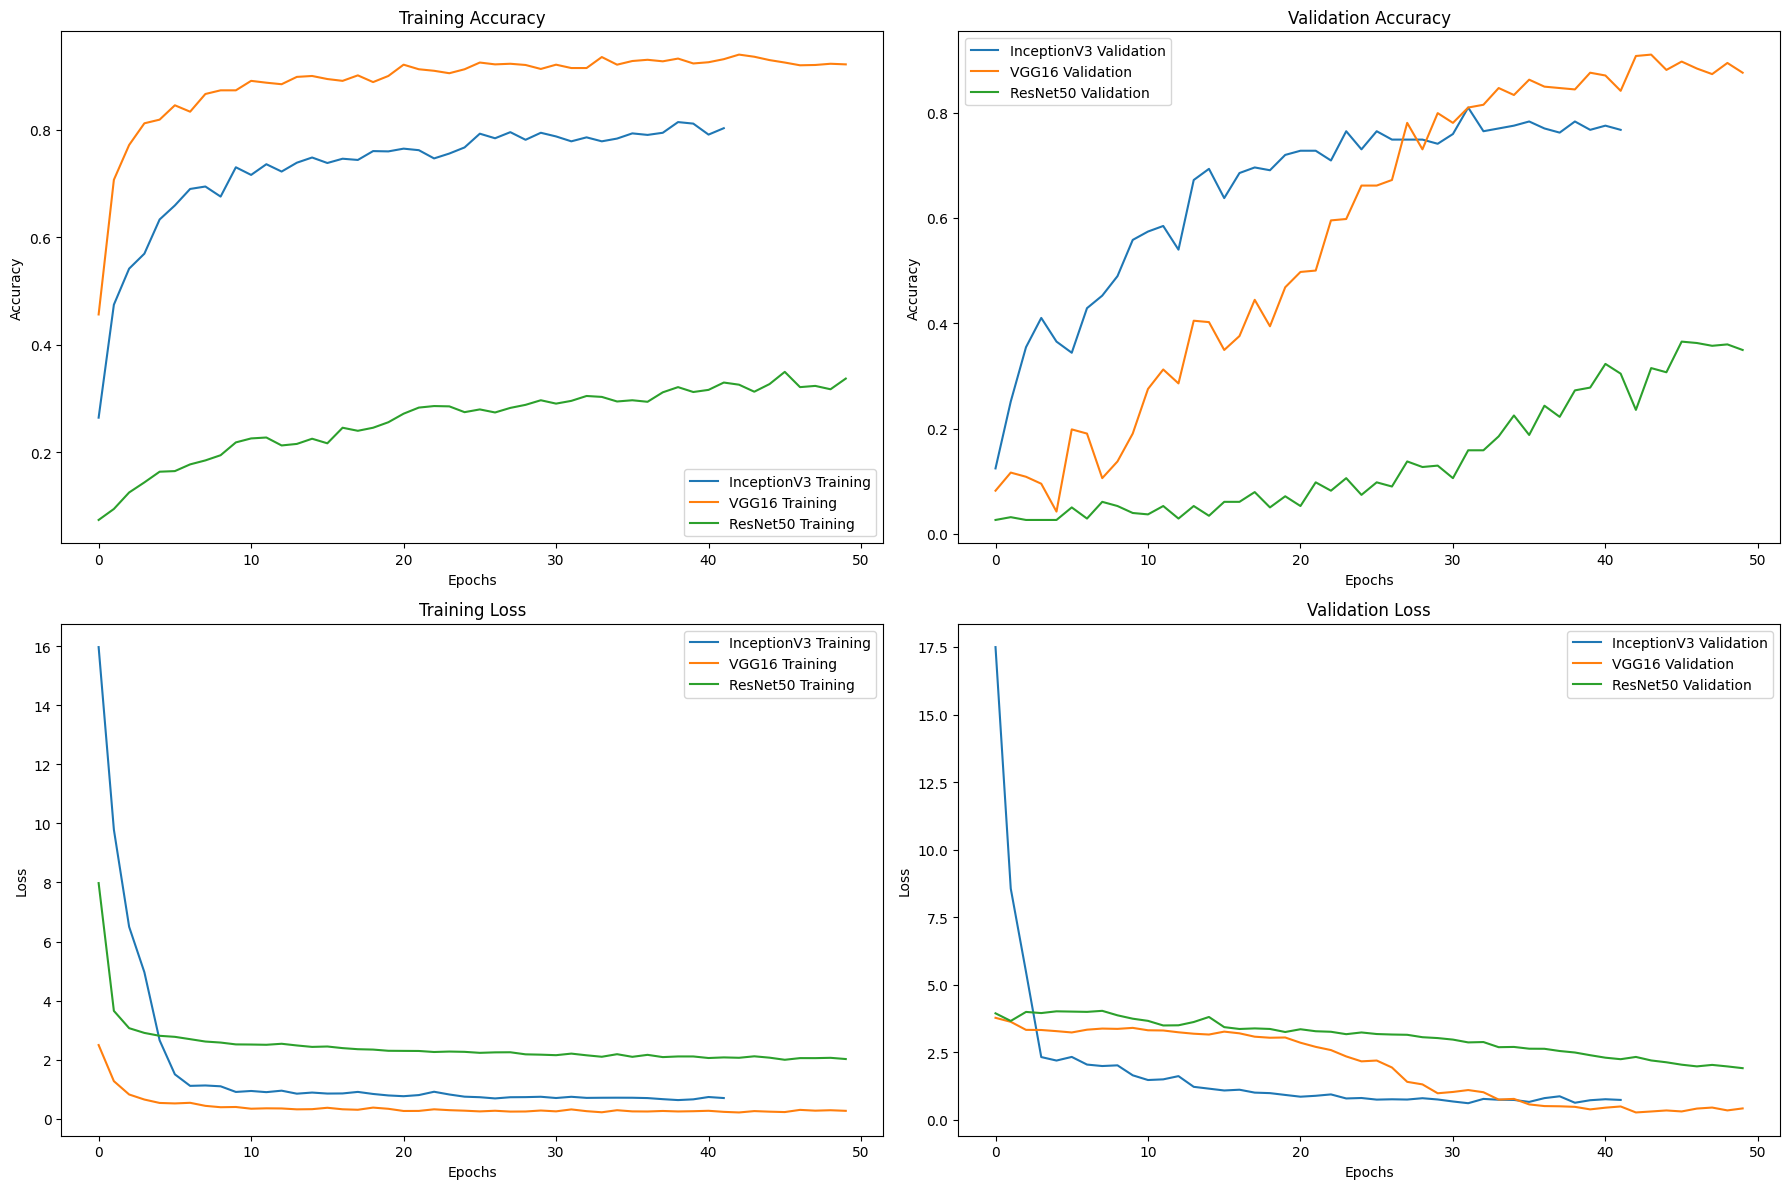

In [ ]:
def plot_training_history(models, model_names):
    plt.figure(figsize=(18, 12))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    for i, model in enumerate(models):
        if 'accuracy' in model.history.history:
            plt.plot(model.history.history['accuracy'], label=f'{model_names[i]} Training')
            plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    for i, model in enumerate(models):
        if 'val_accuracy' in model.history.history:
            plt.plot(model.history.history['val_accuracy'], label=f'{model_names[i]} Validation')
            plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    for i, model in enumerate(models):
        if 'loss' in model.history.history:
            plt.plot(model.history.history['loss'], label=f'{model_names[i]} Training')
            plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    for i, model in enumerate(models):
        if 'val_loss' in model.history.history:
            plt.plot(model.history.history['val_loss'], label=f'{model_names[i]} Validation')
            plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the best models and their names
plot_training_history([best_model_InceptionV3, best_model_VGG16, best_model_ResNet50], ["InceptionV3", "VGG16", "ResNet50"])


### VGG16, InceptionV3, Resnet50 Loss and Accuracy result

Training History for InceptionV3:


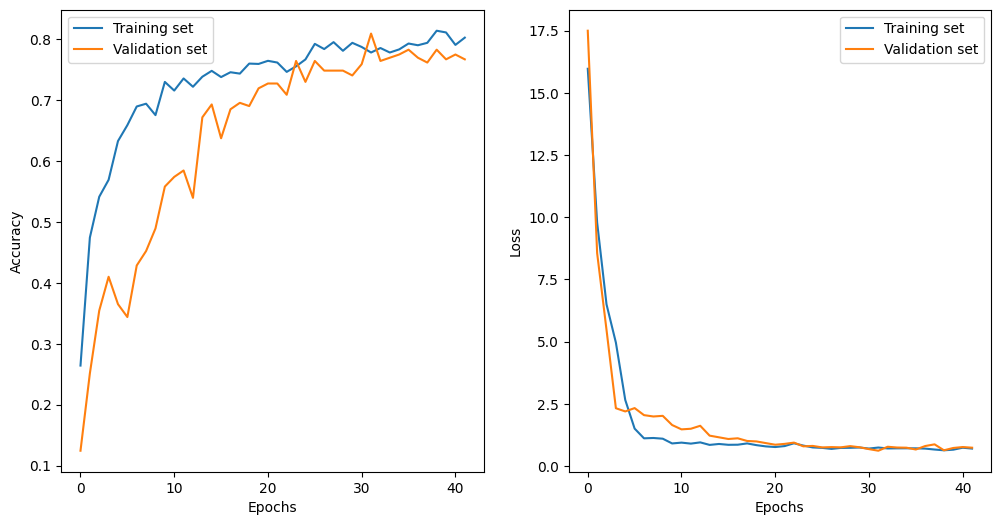

Training History for VGG16:


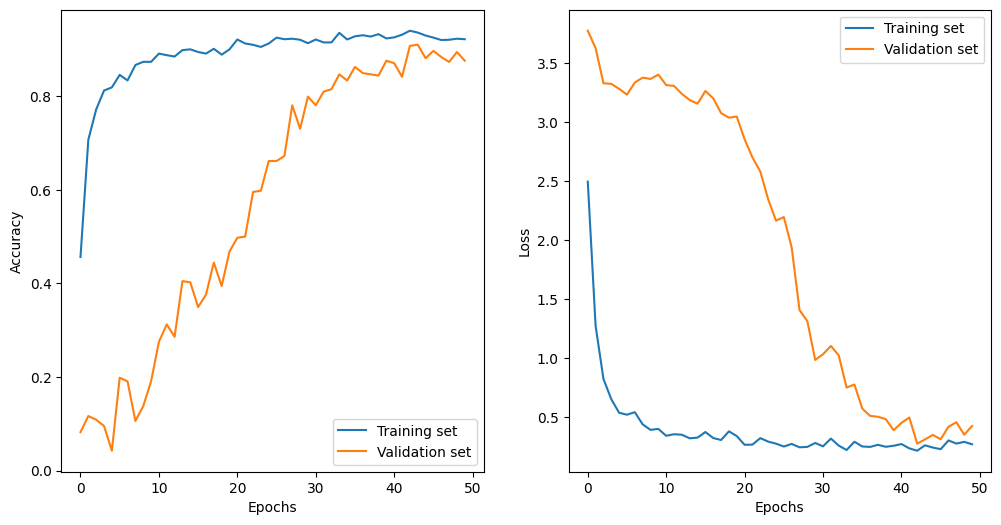

Training History for ResNet50:


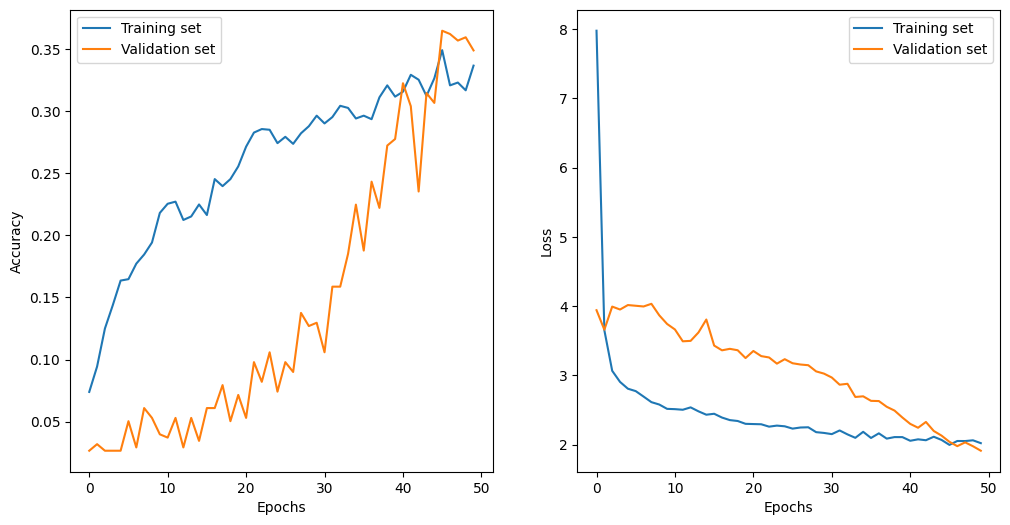

In [ ]:
def plot_training_history(best_model, model_name):
    plt.figure(figsize=(12, 6))

    # Print the name of the model
    print(f"Training History for {model_name}:")

    # Plot train vs validation accuracy
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(best_model.history.history['accuracy'], label='Training set')
    plt.plot(best_model.history.history['val_accuracy'], label='Validation set')
    plt.legend()

    # Plot train vs validation loss
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(best_model.history.history['loss'], label='Training set')
    plt.plot(best_model.history.history['val_loss'], label='Validation set')
    plt.legend()

    plt.show()

# Call the function with the best_model_VGG16
plot_training_history(best_model_InceptionV3, "InceptionV3")
plot_training_history(best_model_VGG16, "VGG16")
plot_training_history(best_model_ResNet50, "ResNet50")

## Test Results

### Test Classification Report VGG16, InceptionV3, Resnet50

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(best_model, test_data):
    # Predict with the best model
    predictions = best_model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_actual = test_data.classes

    # Evaluate the best model on test data
    test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)

    # Print test accuracy and loss
    print('Testing Accuracy:', test_accuracy)
    print('Testing Loss:', test_loss)
    print()

    # Calculate correct vs incorrect predictions
    correct = np.nonzero(y_pred == y_actual)[0]
    incorrect = np.nonzero(y_pred != y_actual)[0]

    print("Correctly predicted classes:", correct.shape[0])
    print("Incorrectly predicted classes:", incorrect.shape[0])
    print()

    # Classification report
    print(classification_report(y_pred, y_actual))

    return y_pred, y_actual, test_accuracy, test_loss

# Call the function with the best_model_VGG16 and test_data
y_pred_VGG16, y_actual_VGG16, test_accuracy_VGG16, test_loss_VGG16 = evaluate_model(best_model_VGG16, test_data)
y_pred_InceptionV3, y_actual_InceptionV3, test_accuracy_InceptionV3, test_loss_InceptionV3 = evaluate_model(best_model_InceptionV3, test_data)
y_pred_ResNet50, y_actual_ResNet50, test_accuracy_ResNet50, test_loss_ResNet50 = evaluate_model(best_model_ResNet50, test_data)

3/3 [==============================] - 5s 2s/step
Testing Accuracy: 0.8673740029335022
Testing Loss: 0.4740408658981323

Correctly predicted classes: 328
Incorrectly predicted classes: 49

              precision    recall  f1-score   support

           0       1.00      0.69      0.81        16
           1       0.70      0.88      0.78         8
           2       1.00      0.83      0.91        12
           3       1.00      1.00      1.00        10
           4       0.82      1.00      0.90         9
           5       1.00      0.92      0.96        12
           6       1.00      0.59      0.74        17
           7       0.90      0.90      0.90        10
           8       1.00      0.92      0.96        12
           9       0.91      1.00      0.95        10
          10       0.80      0.67      0.73        12
          11       0.80      1.00      0.89         8
          12       1.00      1.00      1.00        11
          13       0.91      0.77      0.83        13


### Test Confusion Matrix

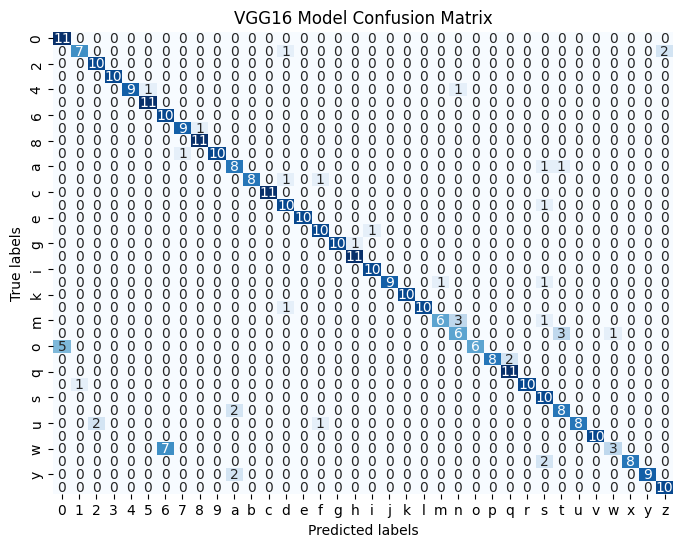

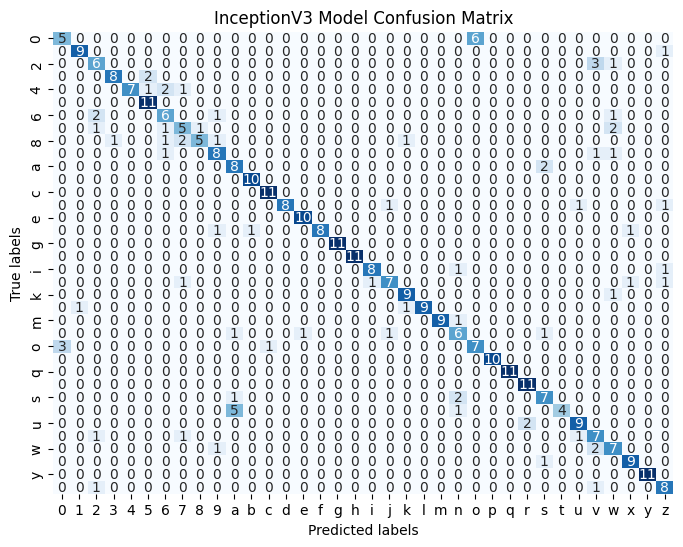

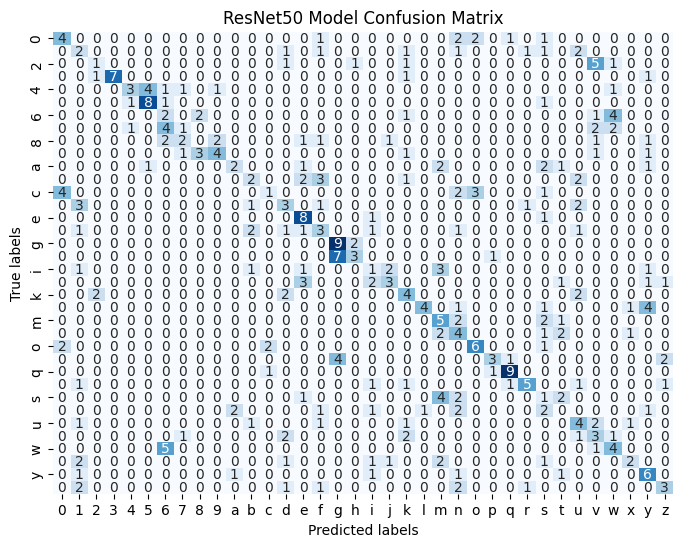

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    matrixdf = pd.DataFrame(matrix, index = categories.values(), columns = categories.values())
    sns.heatmap(matrixdf, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_actual_VGG16, y_pred_VGG16, title="VGG16 Model Confusion Matrix")
plot_confusion_matrix(y_actual_InceptionV3, y_pred_InceptionV3, title="InceptionV3 Model Confusion Matrix")
plot_confusion_matrix(y_actual_ResNet50, y_pred_ResNet50, title="ResNet50 Model Confusion Matrix")


### Accuracy Comparison

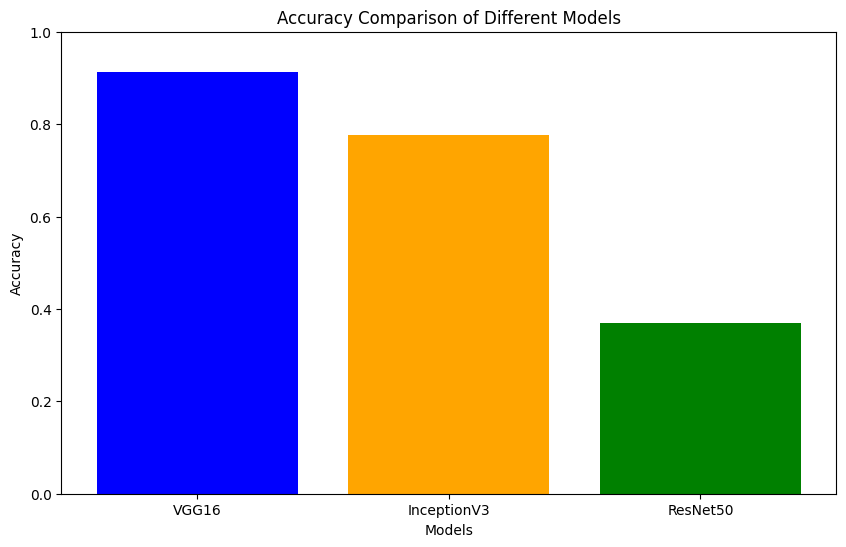

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values for each model
accuracies = [test_accuracy_VGG16, test_accuracy_InceptionV3, test_accuracy_ResNet50]
models = ['VGG16', 'InceptionV3', 'ResNet50']

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.show()


### Test Loss Comparison

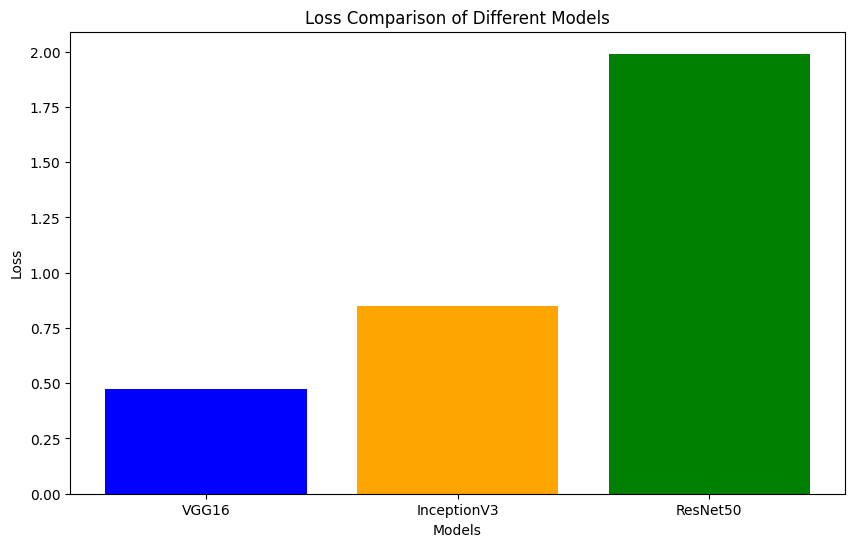

In [ ]:
# Test loss values for each model
losses = [test_loss_VGG16, test_loss_InceptionV3, test_loss_ResNet50]
models = ['VGG16', 'InceptionV3', 'ResNet50']

plt.figure(figsize=(10, 6))
plt.bar(models, losses, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Loss Comparison of Different Models')
plt.show()


## Select best model out of three

In [ ]:
# Test accuracies of each model
test_accuracies = [test_accuracy_VGG16, test_accuracy_InceptionV3, test_accuracy_ResNet50]
model_names = ['VGG16', 'InceptionV3', 'ResNet50']

# Find the index of the model with the highest test accuracy
best_model_index = test_accuracies.index(max(test_accuracies))
best_model_name = model_names[best_model_index]
best_test_accuracy = test_accuracies[best_model_index]

# Append the name of the best model to the test accuracy string
best_model_info = f"The best model based on test accuracy is {best_model_name} with an accuracy of {best_test_accuracy:.2f}."

print(best_model_info)

The best model based on test accuracy is VGG16 with an accuracy of 0.87.


## Sample Output

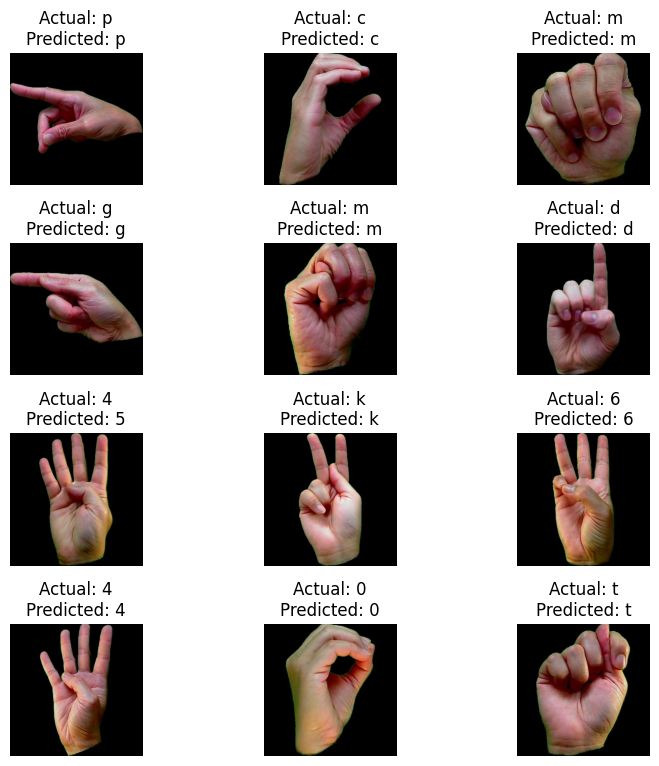

In [ ]:
#visualize 15 predictions
import random

#create reverse dictionary of sign and label
labeldict = {}
for key, value in test_data.class_indices.items():
    labeldict[value] = key

plt.figure(figsize=(8, 8))
for i in range(1, 13):
    plt.subplot(4, 3 ,i)
    plt.tight_layout()
    plt.axis('off')
    randind = random.randint(0, len(test)-1)
    plt.imshow(imread(test.iloc[randind]['file']))
    plt.title(f'Actual: {labeldict[y_actual_VGG16[randind]]}\nPredicted: {labeldict[y_pred_VGG16[randind]]}')